<a href="https://colab.research.google.com/github/JuniorHZ19/CNN-PARA-DETECION-DE-OBJETOS/blob/main/R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

!pip uninstall opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/*
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python-4.10.0.84.dist-info/*
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Test-d435aae7.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.10

In [3]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset

class PascalVOCDataset(Dataset):

    def __init__(self, images_dir, annotations_dir, transform=None):

        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform

        # Lista de todas las imágenes y sus anotaciones
        self.image_filenames = [
            f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))
        ]

    def __len__(self):
        """Devuelve el tamaño del dataset."""
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Devuelve una imagen y su correspondiente anotación.

        Parámetros:
        - idx: Índice de la imagen.

        Retorna:
        - image: Tensor de la imagen.
        - target: Diccionario con bounding boxes y etiquetas.
        """
        # Cargar la imagen
        image_filename = self.image_filenames[idx]

        image_path = os.path.join(self.images_dir, image_filename)
        image = Image.open(image_path).convert("RGB")

        # Cargar la anotación correspondiente
        annotation_path = os.path.join(
            self.annotations_dir, os.path.splitext(image_filename)[0] + ".xml"
        )

        target = self._parse_annotation(annotation_path)


        return np.array(image), target

    def _parse_annotation(self, annotation_path):
        """
        Analiza un archivo XML Pascal VOC y extrae los bounding boxes y etiquetas.

        Parámetros:
        - annotation_path: Ruta del archivo XML.

        Retorna:
        - target: Diccionario con claves:
            'boxes': Lista de bounding boxes en formato [xmin, ymin, xmax, ymax].
            'labels': Lista de etiquetas (clases).
        """
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            label = obj.find("name").text

            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # Convertir labels a índices (si es necesario, define un mapeo de clase a índice)
        label_to_index = {label: idx + 1 for idx, label in enumerate(set(labels))}
        labels = [label_to_index[label] for label in labels]

        target = {
            "boxes":boxes,
            "labels": labels
        }
        return target

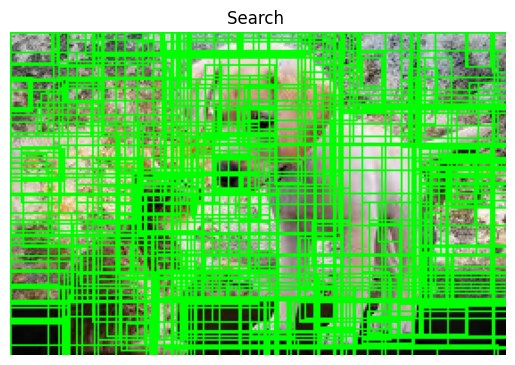

In [6]:
#Creando funcion para generacion de regioness propuestas:

import cv2
import matplotlib.pyplot as plt

# Cargar la imagen
image = cv2.imread('/content/imagenes/0002.jpg')

def get_Region_Proposals(img,max_regiones=2000):
# Crear un objeto de Selective Search
 ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

 image_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Configurar la imagen para Selective Search
 ss.setBaseImage(image_bgr)

# Modo rápido o calidad

 ss.switchToSelectiveSearchFast()  # Más rápido pero menos preciso

 #ss.switchToSelectiveSearchQuality()  # Más preciso pero más lento

# Ejecutar Selective Search para obtener las regiones propuestas
 rects = ss.process()



 return rects[:max_regiones]


rectas_propuestas=get_Region_Proposals(image)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Dibujar las regiones propuestas en la imagen
for (x, y, w, h) in rectas_propuestas:  # Limitar a las primeras 100 regiones para visualizar
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 1)
# Mostrar la imagen con Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

(224, 224, 3)


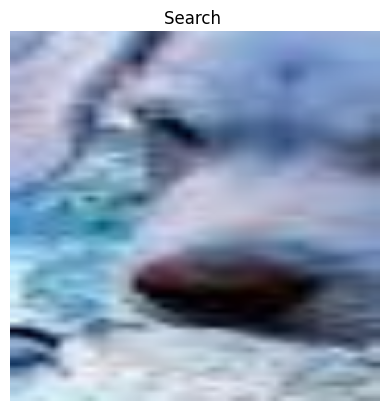

In [7]:
#Funcion redimension dee regiones para entrada al cnn:

def extract_region(image,rect,size=(224,224)):
  x=rect[0]
  y=rect[1]
  w=rect[2]
  h=rect[3]

  if x < 0 or y < 0 or x + w > image.shape[1] or y + h > image.shape[0]:
        raise ValueError("La región extraída excede los límites de la imagen.")
        print(rect)
  region=image[y:y+h, x:x+w] #crop imagen segun recta

  if region.size == 0:  # Verificar si la región extraída es válida
        raise ValueError("La región extraída tiene dimensiones inválidas.")

  img_region=cv2.resize(region, size) #redimensionar para entrada a vgg16 imanges 224x224

  return img_region

img=extract_region(image,rectas_propuestas[100])

print(img.shape)

plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

In [8]:
#funcion calcular iou para comparar la region propuesta con la real:

def calculateIoU(real_bb,predict_bb):

   xl=max(real_bb[0],predict_bb[0]) #maximo entre x de cada extremo top_left de cada bounidnig box
   yl=max(real_bb[1],predict_bb[1]) #maximo entre y de cada extremo top_left de cada bounidnig box

   xr=min(real_bb[2],predict_bb[2]) #min entre x de cada extremo bottom_right de cada bounidnig box
   yr=min(real_bb[3],predict_bb[3]) #min entre y de cada extremo bottom_right de cada bounidnig box

   intersecion_area=(xr-xl)*(yr-yl)  #calculamos el area de la interseccion

   area_realbb=(real_bb[2]-real_bb[0])*(real_bb[3]-real_bb[1]) # calculamos el area del bounding box real con cada una de sus coedenadas
   area_predictbb=(predict_bb[2]-predict_bb[0])*(predict_bb[3]-predict_bb[1]) #calculamos el area del boudnign box predicho con cada una de sus coedenadas

   union_area= (area_realbb + area_predictbb)- intersecion_area #Calculamos el area de la union

   if union_area == 0:
        return 0.0

   IoU= intersecion_area/union_area #calculamos IoU dividiendo la interesccion con la union

   return IoU





In [15]:
#Selecionar regiones propuestas que iran al  modelo SVM  usando criterio de IoU donde  <0.3 sera considerados como fondo ,0.3< IoU <0.5 sera omitido para evitar ambuiguidad
#Mayores a 0.5> sera clasificado como la clase del bbox que mas se apropixma al IoU.

def select_labels_regiones(regiones, ground_truth_boxes, ground_truth_labels, iou_threshold=0.7):

  labels=[]
  regiones_selected=[]
  real_bbox_selected=[]
  for region in regiones:
    max_iou = 0
    best_label = 0  # Inicializar como fondo por defecto
    best_box = None

    for box, gt_label in zip(ground_truth_boxes, ground_truth_labels):

        iou = calculateIoU(region, box)
        if iou > max_iou:  #se quedara con el mayor iou conseguido de los objetos que coincida asi no tener probelmas de etiquetar fondo si se pasa a los siguientes boxes
            max_iou = iou
            if iou <=0.3:
              best_label = 0
              best_box = None

            elif  0.3<iou<iou_threshold:
               best_label = 'no seleccionada'
               best_box = None

            elif  iou >= iou_threshold:  # Verifica si el IoU supera el umbral
                best_label = gt_label
                best_box = box

    if best_label != 'no seleccionada':
     regiones_selected.append(region)
     real_bbox_selected.append(best_box)
     labels.append(best_label)


  return regiones_selected,real_bbox_selected,labels

#selecionamos el bbox real de cada bbox que se propuesto y contenga un objeto (iou>0.7) y no consideremos el fondo, esto para entrenar el modelo regresor

def select_bbox_regiones(regiones_selected,real_regiones_selected,labels):

    real_bboxs=[]
    regiones=[]
    labels_selected=[]
    for region,real_bbox,label in zip(regiones_selected,real_regiones_selected,labels):

        if label!='fondo' and  label!=0:
            real_bboxs.append(real_bbox)
            regiones.append(region)
            labels_selected.append(label)



    return regiones,real_bboxs,labels_selected





In [10]:
#funciones para calcular las ranfomaciones (que tanto se desplza el boudnig box propuesto del real t_x, t_y, t_w, t_h) cual entrara al regresor que calcuialra estos translacion

def calculate_translation(bbox_pred, bbox_real):
    """
    Calcula la traducción necesaria para ajustar un bbox predicho a su equivalente real.

    Args:
        bbox_pred: (xmin_pred, ymin_pred, xmax_pred, ymax_pred)
        bbox_real: (xmin_real, ymin_real, xmax_real, ymax_real)

    Returns:
        translation: (dx, dy) -> Desplazamiento en x e y
    """
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = bbox_pred
    xmin_real, ymin_real, xmax_real, ymax_real = bbox_real

    dx = xmin_real - xmin_pred
    dy = ymin_real - ymin_pred

    return [dx, dy]

import numpy as np

def apply_translation_to_bbox(bbox_pred, translation):
    """
    Aplica una transformación de traducción a un bounding box.

    Args:
        bbox: (xmin, ymin, xmax, ymax)
        translation: (dx, dy) -> cantidad de desplazamiento en x e y

    Returns:
        new_bbox: (xmin', ymin', xmax', ymax')
    """
    xmin, ymin, xmax, ymax = bbox_pred
    dx, dy = translation

    new_xmin = xmin + dx
    new_ymin = ymin + dy
    new_xmax = xmax + dx
    new_ymax = ymax + dy

    return (new_xmin, new_ymin, new_xmax, new_ymax)

In [11]:
#Crear extractor de  features con VGG16:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import cv2
import numpy as np




def extract_features_from_regions(image,regiones,modelo):

    all_features = []
    # Definir las transformaciones para preprocesar las imágenes
    transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar según ImageNet
    ])

    for region in regiones:

        region_extracted=extract_region(image,region)

        # Convertir la región redimensionada a tensor
        input_tensor = transform(region_extracted).to(device)
        input_tensor = input_tensor.unsqueeze(0)  # Añadir batch dimension
        input_tensor = Variable(input_tensor)

        # Extraer características usando VGG16
        with torch.no_grad():
            features = modelo.features(input_tensor)  # Extraer las características
            flattened = features.view(features.size(0), -1)
        all_features.append(flattened.squeeze().cpu().numpy())  # Almacenar las características

    return np.array(all_features)



In [12]:
from torchvision import transforms
import numpy as np
from torch.utils.data import Dataset, random_split
# Directorios del dataset
images_dir = "/content/imagenes"
annotations_dir = "/content/anotaciones"

# Definir transformaciones (opcional)
transform = transforms.Compose([
    transforms.ToTensor() # Convierte la imagen a tensor

])

# Crear el dataset
dataset = PascalVOCDataset(images_dir, annotations_dir, transform=transform)

# Particionar dataset en train y test
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
test_size = len(dataset) - train_size  # El resto para prueba

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
img,target=train_dataset[2]
print(target)
print(img.shape)

{'boxes': [[296, 88, 896, 900]], 'labels': [1]}
(900, 1200, 3)


In [37]:
#ENTRENAR CLASFICADOR SVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression


# SVM modelo
svm = SVC(kernel='rbf', C=1.0, probability=True)

vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()
# Número de épocas
epochs = 1

for epoch in range(epochs):
    accuraty_total = 0

    for image, target in train_dataset:
        # Obtener regiones propuestas
        regiones_propuestas = get_Region_Proposals(image, max_regiones=2000)
        # Seleccionar regiones
        regiones_selected, real_bbox_selected, labels = select_labels_regiones(regiones_propuestas, target['boxes'], target['labels'])
        # Extraer características
        features = extract_features_from_regions(image,regiones_selected,vgg16)
        print(labels)
        # Entrenar el SVM
        svm.fit(features, labels)

    # Evaluar en el conjunto de prueba
    for image_test, target_test in test_dataset:
        regiones_propuestas = get_Region_Proposals(image_test, max_regiones=2000)
        regiones_selected_test, real_bbox_selected_test, labels_test = select_labels_regiones(regiones_propuestas, target_test['boxes'], target_test['labels'])
        features_test = extract_features_from_regions(image_test,regiones_selected_test,vgg16)

        y_pred = svm.predict(features_test)

        accuraty_total += accuracy_score(y_pred, labels_test)

    accuraty_total /= len(test_dataset)
    print(f"Precisión del SVM: {accuraty_total:.2f}")
    print(features.shape)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 

<ipython-input-8-86e42c3ff26e>:18: RuntimeWarning: divide by zero encountered in scalar divide
  IoU= intersecion_area/union_area #calculamos IoU dividiendo la interesccion con la union


[0, 1, 0, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0, 2, 2, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 0, 1, 1, 2, 0, 2, 0, 1, 1, 2, 1, 2, 1, 0, 0, 1, 0, 2, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 

In [38]:
#ENTRENTAR REGRESOR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import numpy as np




regressor = LinearRegression()

vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()
# Número de épocas
epochs = 1

for epoch in range(epochs):
    accuraty_total = 0

    for image, target in train_dataset:
        # Obtener regiones propuestas
        regiones_propuestas = get_Region_Proposals(image, max_regiones=2000)
        # Seleccionar regiones
        regiones_selected, real_bbox_selected, labels = select_labels_regiones(regiones_propuestas, target['boxes'], target['labels'])

        #selecionar bbox para entrnemaiento evitando los fondos


        regiones,real_bboxs,labels_selected=select_bbox_regiones(regiones_selected,real_bbox_selected,labels)
        print(labels_selected)
        # Extraer características
        features = extract_features_from_regions(image,regiones,vgg16)

        translations=[]

        for region,truth_box in zip(regiones,real_bboxs):
          translations.append(calculate_translations(region,truth_box))
        print(len(translations))
        print(features.shape)
        regressor.fit(features, np.array(translations))









/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

<ipython-input-8-86e42c3ff26e>:18: RuntimeWarning: divide by zero encountered in scalar divide
  IoU= intersecion_area/union_area #calculamos IoU dividiendo la interesccion con la union


[2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 

In [45]:
#prediccion con imagen:

url = "/content/imagenes/0016.jpg"  # @param {type:"string"}

image = cv2.imread(url)

regiones_propuestas = get_Region_Proposals(image, max_regiones=2000)

features = extract_features_from_regions(image, regiones_propuestas, vgg16)

clases = svm.predict(features)
probas = svm.predict_proba(features)
translations = regressor.predict(features)

for clase, prob, translation, region_propuesta in zip(clases, probas, translations, regiones_propuestas):
    if clase != 'fondo' and clase != 0 and prob.max() > 0.9:
        print(prob.max())
        pred_bbox = apply_translation_to_bbox(region_propuesta,translation)

        cv2.rectangle(image, (int(pred_bbox[0]), int(pred_bbox[1])), (int(pred_bbox[2]), int(pred_bbox[3])), (0, 255, 0), 2)

plt.imshow(image)
plt.axis('off')  # Desactivar los ejes para mostrar solo la imagen
plt.show()


0.9846381108782968


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2
